In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import json
import mrcfile
import umap

from cryo_sbi.inference.models import build_models
from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors
import cryo_sbi.utils.estimator_utils as est_utils
from cryo_sbi.utils.image_utils import (
    LowPassFilter,
    NormalizeIndividual,
    MRCtoTensor,
    FourierDownSample,
    Mask,
)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load posterior surrogate

In [4]:
posterior_config_file = (
    "../experiments/6wxb/resnet18_fft_encoder.json"  # "PATH_TO_NN_CONFIG"
)
posterior_weights_file = (
    "../experiments/6wxb/posterior_6wxb_mixed.estimator"  # "PATH_TO_NN_WEIGHTS"
)

estimator = est_utils.load_estimator(
    posterior_config_file, posterior_weights_file, device=device
)

## Test posterior with simulated images

In [20]:
image_config_file = "../experiments/6wxb/image_params_mixed_training.json"
cryo_em = CryoEmSimulator(image_config_file)
cryo_em.config["SNR"] = 0.01  # Fixing the SNR, set range with [lower, upper]
cryo_em.config["SIGMA"] = 1.0  # Fixing the Sigma, set range with [lower, upper]

../data/protein_models/6wxb_mixed_models.npy


#### Simulate a single image and infer the conformation

In [21]:
synthetic_image = cryo_em.simulator(torch.tensor([50.0]))
samples = est_utils.sample_posterior(
    estimator, synthetic_image.unsqueeze(0), num_samples=10000, device=device
)  # we need to use unsqueeze becase we are using a single image

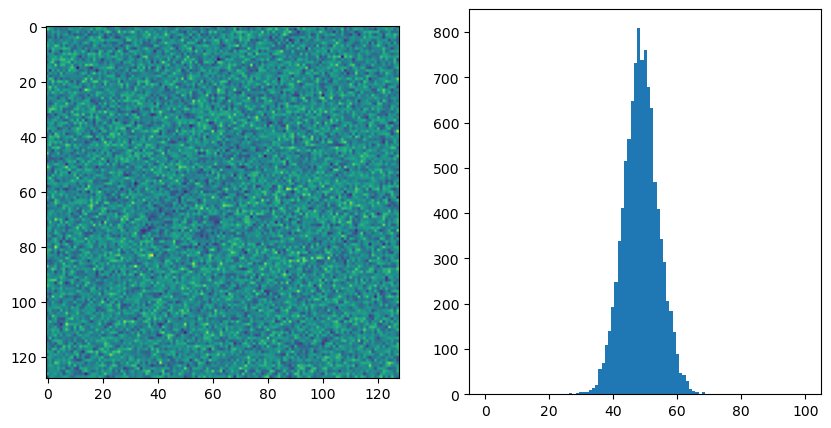

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = ax[0].imshow(synthetic_image)
_ = ax[1].hist(samples.flatten(), bins=np.linspace(0, cryo_em.max_index, 100))

#### Test posterior on 20 images

In [23]:
indices = torch.tensor(np.arange(0, cryo_em.max_index + 1, 5), dtype=float).reshape(
    -1, 1
)
images = torch.stack([cryo_em.simulator(index) for index in indices], dim=0)

In [24]:
samples = est_utils.sample_posterior(
    estimator, images, num_samples=10000, device=device
)

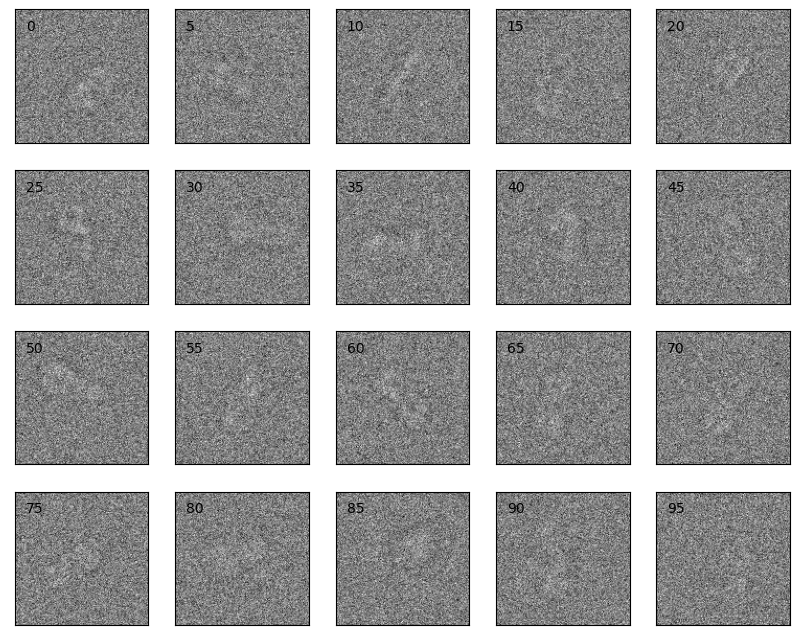

In [25]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[idx], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(10, 20, str(int(indices[idx].item())))

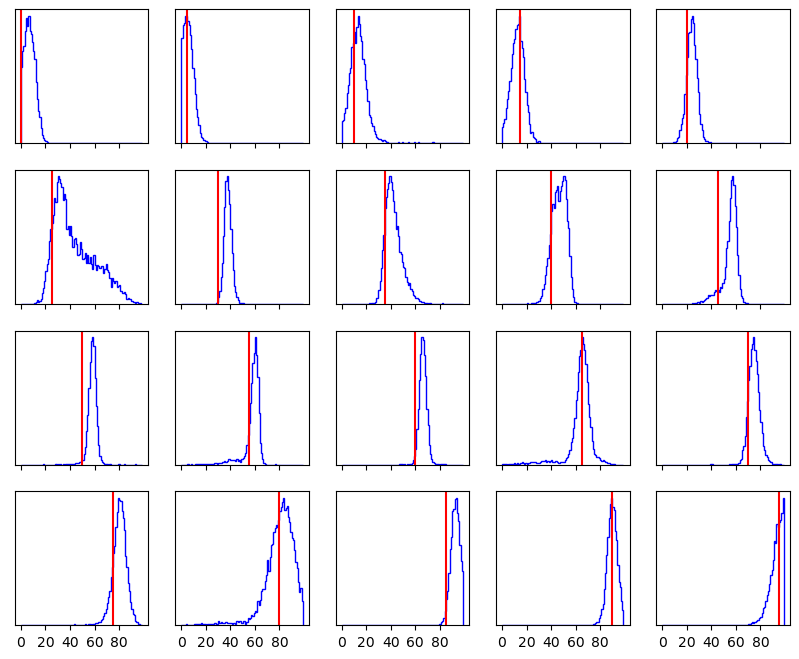

In [26]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for idx, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples[:, idx].flatten().numpy(),
        bins=np.arange(0, 100, 1),
        histtype="step",
        color="blue",
        label="all",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 100, 20))
    ax.axvline(indices[idx], color="red")

#### If you want we can also test the posterior with SBCC (This may take a while)


In [27]:
from lampe.data import JointLoader
from lampe.diagnostics import expected_coverage_mc
from lampe.plots import coverage_plot
from cryo_sbi.inference import priors
from itertools import islice

In [28]:
loader = JointLoader(
    priors.get_uniform_prior_1d(cryo_em.max_index),
    cryo_em.simulator,
    vectorized=False,
    batch_size=1,
    num_workers=24,  # You might wanna change this
    prefetch_factor=1,
)

levels, coverages = expected_coverage_mc(
    estimator.flow,
    (
        (estimator.standardize(theta.cuda()), x.cuda())
        for theta, x in islice(loader, 500)
    ),  # We use here just 500 samples, this is not really accurate but gives us an idea
)

49pair [00:06,  7.33pair/s]


KeyboardInterrupt: 

In [ ]:
coverage_plot(levels, coverages);

## Now let's look at experimental images

In [29]:
# We use parts of the torchvision module to take care of imigae processing
# We can build a transformation which modify our images in a predefined pipline
transform = transforms.Compose(
    [
        MRCtoTensor(),  # Load mrc file (str) and construct pytorch tensor
        transforms.Resize(size=(128, 128)),  # Resize image to given size
        NormalizeIndividual(),  # Normalize image
    ]
)

# Example transformation, we can do more then just normalization
transform_test = transforms.Compose(
    [
        MRCtoTensor(),
        FourierDownSample(256, 128),
        NormalizeIndividual(),
        Mask(128, 45),
        LowPassFilter(128, 80),
    ]
)

You can download the particles directly here : https://www.ebi.ac.uk/empiar/EMPIAR-10532/

In [30]:
experimental_images = transform(
    "../../6wxb/particles/particles_01.mrc"
)  # Here the images are loaded, resized and normalized

FileNotFoundError: [Errno 2] No such file or directory: '../../6wxb/particles/particles_01.mrc'

In [ ]:
# In case you want to load more than just one mrc file
experimental_images = []
for i in range(1, 17):
    if i < 10:
        img_file = f"../../6wxb/particles/particles_0{i}.mrc"
    else:
        img_file = f"../../6wxb/particles/particles_{i}.mrc"
    tmp_images = transform(img_file)
    experimental_images.append(tmp_images)

experimental_images = torch.cat(experimental_images, dim=0)

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(experimental_images[idx], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])

## Finally we test the posterior on the real images

In [ ]:
samples_exp = est_utils.sample_posterior(
    estimator, experimental_images, num_samples=10000, device=device
)

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for idx, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples_exp[:, idx].flatten().numpy(),
        bins=np.arange(0, 100, 1),
        histtype="step",
        color="blue",
        label="all",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 100, 20))

##### Since we can look at all posteriors, lets look at all the posterior means

In [ ]:
posterior_mean = samples_exp.mean(axis=0)

In [ ]:
_ = plt.hist(posterior_mean)

##### Some of the posterior might be to wide, so lets exclude them 

In [ ]:
posterior_quantiles = np.quantile(samples_exp.numpy(), [0.025, 0.975], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()
condition = (
    confidence_widths < 50
)  # Select posterior with a 95% confidence intervall less the 50 indices
posterior_idx = np.where(condition)[0]

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for idx, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples_exp[:, posterior_idx[idx]].flatten().numpy(),
        bins=np.arange(0, 100, 1),
        histtype="step",
        color="blue",
        label="all",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 100, 20))

In [ ]:
posterior_mean = samples_exp[:, posterior_idx].mean(axis=0)

In [ ]:
_ = plt.hist(posterior_mean)